## **Предсказание стоимости автомобиля**

**Цель исследования:**

Построить модель для определения стоимости автомобиля, с учетом качества предсказания, скорости предсказания и времени обучения. При оценке качества использовать метрику RMSE.

**Ход исследования:**
- Загрузка и подготовка данных.
- Обучение разных моделей и поиск лучшей.
- Проведение анализа скорости и качества моделей



**Описание данных:**

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

In [1]:
# установим последнюю версию scikit-learn, если она не установлена
# теперь для OneHotEncoder работает одновремеено drop='first' и handle_unknown='ignore'
!pip -q install scikit-learn==1.1.3

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import random
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder

In [3]:
from sklearn.model_selection import ParameterGrid
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
from tqdm.notebook import tqdm

## 1. Загрузите и подготовьте данные

### 1.1. Обзор данных

In [4]:
try:
    data = pd.read_csv("/datasets/autos.csv")
except:
    data=pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', error_bad_lines=False)
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### 1.2. Поиск особенностей в данных

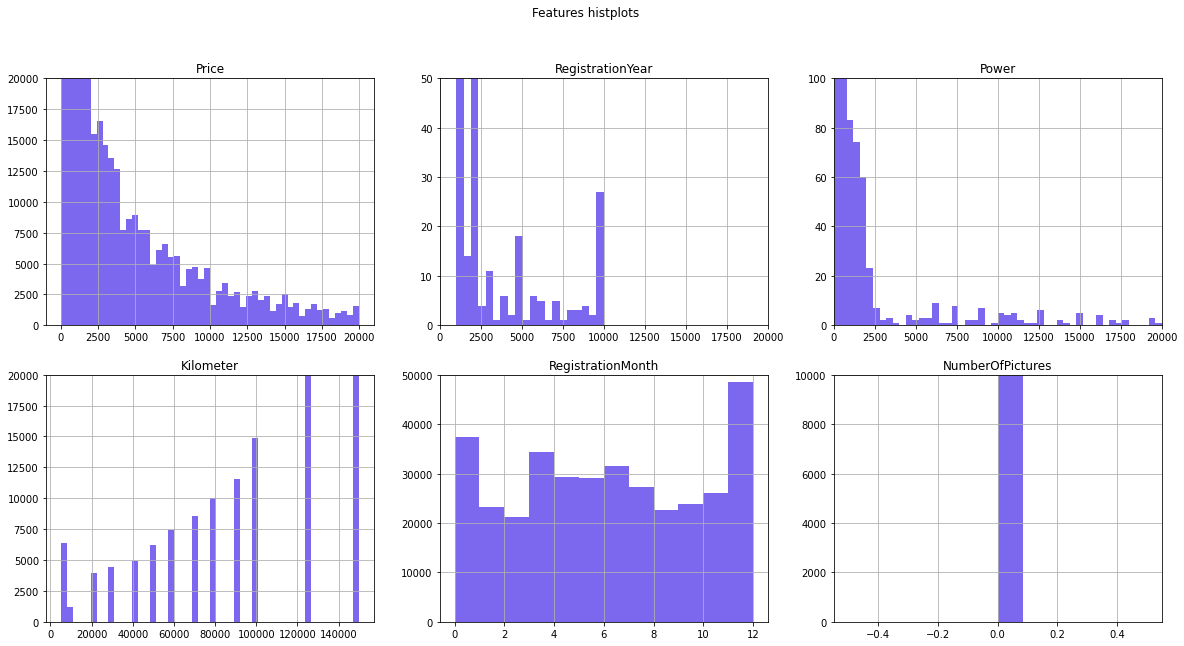

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Features histplots')
i=0
j=0
y_limits = [[20000, 50, 100], [20000, 50000, 10000]]
x_limits = [[300000, 300000,300000], [150000, 50, 1000]]
bins = [[50, 20, 50], [50, 12, 12]]

for column in ['Price', "RegistrationYear", "Power", "Kilometer", "RegistrationMonth", "NumberOfPictures"]:
    data[column].hist(bins = bins[i][j] , ax=axes[i][j],color = "mediumslateblue")
    axes[i][j].set_title(column)
    axes[i][j].set_ylim(0, y_limits[i][j])
    if i!=1 and j!=0:
        axes[i][j].set_xlim(0, 20000)
    j+=1
    if j==3:
        i+=1
        j=0
    if i==2:
        break

plt.show()

In [6]:
data["RegistrationYear"].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [7]:
data["Price"].sort_values().unique()

array([    0,     1,     2, ..., 19998, 19999, 20000])

In [8]:
data["NumberOfPictures"].sort_values().unique()

array([0])

In [9]:
data["DateCreated"].sort_values().unique()

array(['2014-03-10 00:00:00', '2015-03-20 00:00:00',
       '2015-06-18 00:00:00', '2015-08-07 00:00:00',
       '2015-08-10 00:00:00', '2015-09-04 00:00:00',
       '2015-09-09 00:00:00', '2015-11-02 00:00:00',
       '2015-11-08 00:00:00', '2015-11-10 00:00:00',
       '2015-11-12 00:00:00', '2015-11-17 00:00:00',
       '2015-11-23 00:00:00', '2015-11-24 00:00:00',
       '2015-12-05 00:00:00', '2015-12-06 00:00:00',
       '2015-12-17 00:00:00', '2015-12-27 00:00:00',
       '2015-12-30 00:00:00', '2016-01-02 00:00:00',
       '2016-01-03 00:00:00', '2016-01-06 00:00:00',
       '2016-01-07 00:00:00', '2016-01-08 00:00:00',
       '2016-01-10 00:00:00', '2016-01-13 00:00:00',
       '2016-01-15 00:00:00', '2016-01-16 00:00:00',
       '2016-01-17 00:00:00', '2016-01-18 00:00:00',
       '2016-01-19 00:00:00', '2016-01-20 00:00:00',
       '2016-01-22 00:00:00', '2016-01-23 00:00:00',
       '2016-01-24 00:00:00', '2016-01-25 00:00:00',
       '2016-01-26 00:00:00', '2016-01-27 00:0

Как видим - среди признаков неинформативным является признак с числом картинок в объявлении, его можно удалить, т.к. все значения в нем сосредоточены в 0. Также можно заметить странную особенность - в столбце Price не менее 20000 объявлений с нулевой стоимостью. Таже имеются позиции в столбце Power существуют объекты с нулевой мощностью или мощностью, превышающей 2500 л.с. Также в столбце RegistrationYear наблюдаем значения, превышающие текущий год или значения ранее 1900г. Столбцы с датами создания анкеты, последней активности пользователя и даты скачивания анкеты не являются значимыми.

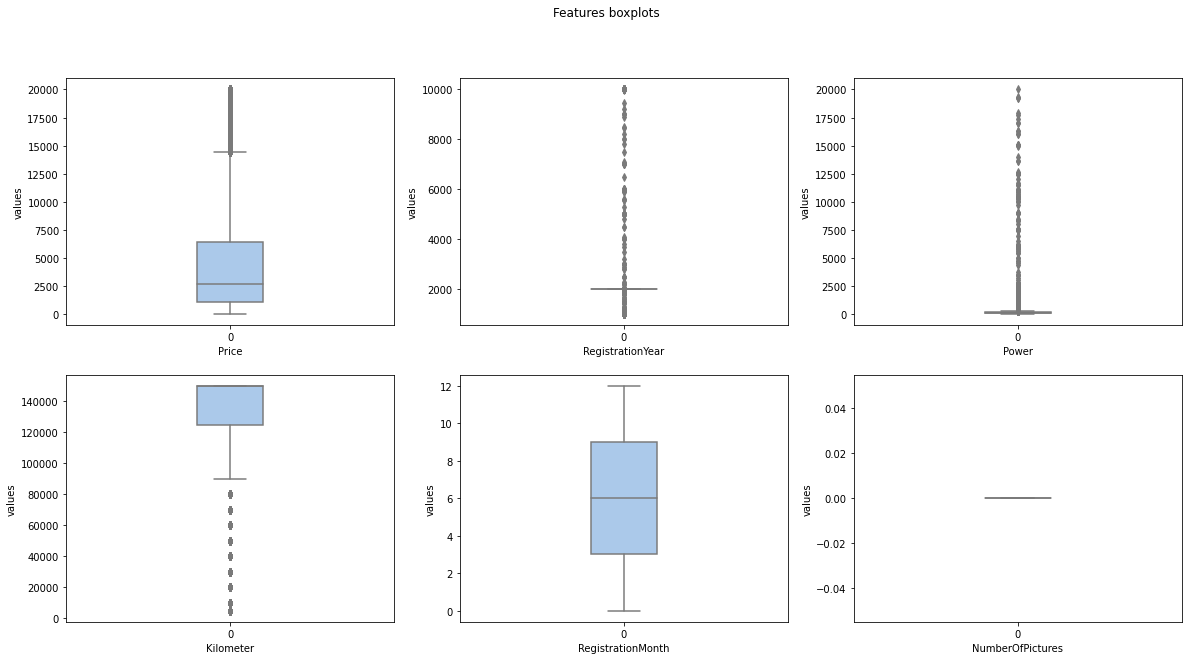

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Features boxplots')
i=0
j=0

for column in ['Price', "RegistrationYear", "Power", "Kilometer", "RegistrationMonth", "NumberOfPictures"]:
        sns.set_palette("pastel")
        sns.set_style("whitegrid")
        sns.boxplot(ax=axes[i][j],data = data[column]).set( xlabel = column, ylabel = 'values', xlim=(-2, 2))
        j+=1
        if j==3:
            i+=1
            j=0
        if i==2:
            break
plt.show()

### 1.3. Удаление неинформативных признаков

In [11]:
data = data.drop(columns= ["NumberOfPictures", "PostalCode", "DateCrawled", "LastSeen", "DateCreated"])

### 1.4. Обработка аномальных значений и пропусков в данных

In [12]:
print("Число строк с пропусками больше трех", data[data.isnull().sum(axis=1) >= 4]["Price"].count())

Число строк с пропусками больше трех 8020


В данных присутствуют пропуски. Средний процент пропущенных значений по столбцам составляет 10%-12%. В столбце Repaired пропусков близится к 20%, что составляет значительную часть данных. 

In [13]:
data = data[data.isnull().sum(axis=1) < 4]
print("before")
print(data.isna().sum())
for column in ["VehicleType", "Gearbox", "Model", "FuelType", 'Repaired']:
    data[column] = data[column].fillna("unknown")
print()
print("after")
print(data.isna().sum())

before
Price                    0
VehicleType          29829
RegistrationYear         0
Gearbox              12664
Power                    0
Model                15659
Kilometer                0
RegistrationMonth        0
FuelType             25319
Brand                    0
Repaired             63289
dtype: int64

after
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64


Обработка аномальных значений

In [14]:
print("Число аномальных значений в столбце Price:", data.loc[data["Price"] <= 10, "Price"].count())
print("Число аномальных значений в столбце Power:", data.loc[(data["Power"] < 5) | (data["Power"] > 2500), "Power"].count())
print("Число аномальных значений в столбце RegistrationYear:", data.loc[(data["RegistrationYear"] > 2023) | (data["RegistrationYear"] < 1910), "RegistrationYear"].count())

Число аномальных значений в столбце Price: 10052
Число аномальных значений в столбце Power: 34119
Число аномальных значений в столбце RegistrationYear: 51


Процент аномальных данных довольно высок, данные с пропущенным годом и ценой можно удалить, а вот данные с незаполненной мощностью постараться заполнить.

In [15]:
data = data[(data["RegistrationYear"] > 1910) & (data["RegistrationYear"] < 2023)]
data = data[data["Price"] > 10].reset_index(drop=True)

In [16]:
data[(data["Power"] < 5) | (data["Power"] > 2500)]["Price"].count()
data[(data["Power"] < 5) | (data["Power"] > 2500)].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
30,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no
35,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no
51,4700,wagon,2005,manual,0,signum,150000,0,unknown,opel,no
52,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes


Найдем медианные значения мощности в зависимости от типа автомобиля. Этими данными заполним пропуски в соответствующем стобце.

In [17]:
median_power = data.groupby('Model')["Power"].agg('median')

for model in data['Model'].unique():
    data.loc[(data["Power"] < 5) | (data["Power"] > 2500) & (data["Model"] == model), "Power"] = median_power[model]

In [18]:
data[(data["Power"] < 5) | (data["Power"] > 2500)]["Price"].count()

0

Таким образом мы полностью избавились от аномальных значений в данных и обработали все пропуски.

### 1.5. Проверка наличия дубликатов

In [19]:
print("Число явных дубликатов:", data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)

Число явных дубликатов: 25644


После удаления неинформативных признаков число явных дубликатов выросло с 5 до 25664. Эти данные мы удалим.

In [20]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unknown,1993,manual,100.0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no


### 1.6. Проверка мультиколлинеарности признаков

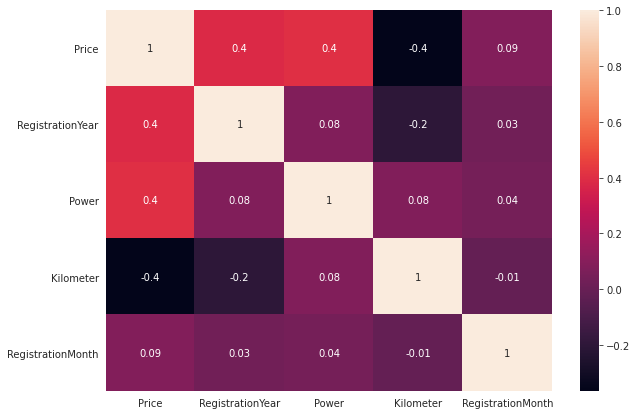

In [21]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,7))

sns.heatmap(data.corr(), annot=True, fmt='.1g')
plt.show()

Среди признаков не наблюдается сильной коллинеарности.

По итогу раздела был осуществлен обзор датафрейма, обработаны пропуски и аномалии в данных, произведена проверка на наличие дубликатов, признаки проверены на мультиколлинеарность, удалены незначимые признаки.

## 2. Обучение модели.

### 2.1. Разделение на тренировочную, тестовую и валидационную выборки

In [22]:
def split_sample(data):
    features = data.drop(columns=['Price'])
    target = data['Price']
    train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=12345)
    train_features, valid_features, train_target, valid_target = train_test_split(train_features, train_target, test_size=0.22, random_state=12345)
    train_features.head()
    print("Размеры тренировочной, валидационной,тестовой выборок:")
    print(train_features.shape, valid_features.shape, test_features.shape)

    return train_features, valid_features, test_features, train_target,  valid_target, test_target

In [23]:
train_features, valid_features, test_features, train_target,  valid_target, test_target = split_sample(data)

Размеры тренировочной, валидационной,тестовой выборок:
(193811, 10) (54665, 10) (62120, 10)


### 2.2. Кодирование категориальных признаков

In [24]:
cat_cols = ["VehicleType", "Gearbox", "Brand", "FuelType", 'Repaired']

In [25]:
enc_ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

enc_ohe.fit(train_features[cat_cols])
enc_oe.fit(train_features[["Model"]])
def encoding_data(df):
    df[enc_ohe.get_feature_names_out()] = enc_ohe.transform(df[cat_cols])
    df = df.drop(columns = cat_cols)
    df["Model"] = enc_oe.transform(df[["Model"]])
    return df

In [26]:
train_features = encoding_data(train_features)
valid_features = encoding_data(valid_features)
test_features = encoding_data(test_features)

In [27]:
print("Размеры тренировочной, валидационной,тестовой выборок:")
print(train_features.shape, valid_features.shape, test_features.shape)

Размеры тренировочной, валидационной,тестовой выборок:
(193811, 68) (54665, 68) (62120, 68)


Категориальные данные были закодированы при помощи сочетания методов кодирования OHE & OE.

### 2.3. Маштабирование признаков

In [28]:
def scaled_features(train_features, valid_features, test_features):
    scaler = StandardScaler()
    num_features = ["RegistrationYear", "Power", "Kilometer", "RegistrationMonth"]
    scaler.fit(train_features.loc[:, num_features]) 

    train_features_scaled = scaler.transform(train_features.loc[:, num_features])
    valid_features_scaled = scaler.transform(valid_features.loc[:, num_features])
    test_features_scaled = scaler.transform(test_features.loc[:, num_features])
    pd.options.mode.chained_assignment = None

    for i, column in enumerate(["RegistrationYear", "Power", "Kilometer", "RegistrationMonth"]):
        train_features[column]= train_features_scaled[:, i]
        test_features[column]= test_features_scaled[:, i]
        valid_features[column]= valid_features_scaled[:, i]
    return train_features, valid_features, test_features


In [29]:
train_features, valid_features, test_features = scaled_features(train_features, valid_features, test_features)


In [30]:
train_features.head()

,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Repaired_no,Repaired_unknown,Repaired_yes
74612,0.666821,3.926818,19.0,-1.045573,-0.771931,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
52375,-0.021055,0.185702,29.0,0.577445,-1.318614,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
300091,0.391671,0.328372,28.0,-0.098812,-1.045272,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
302382,-2.634980,-0.702020,129.0,0.577445,-0.498589,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
14974,-0.571355,-0.939803,5.0,-1.316076,-1.045272,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### 2.3. Обучение разных моделей с подбором гиперпараметров и поиск лучшей.

In [77]:
times = {"lr":[], "lgbm":[], "nn":[]}

#### 2.3.1 Линейная регрессия

In [78]:
start_time = time.time()

model = LinearRegression()
model.fit(train_features, train_target)

times["lr"].append((time.time() - start_time))
print("Время обучения %s" % times["lr"][0])

start_time = time.time()
valid_predictions = model.predict(valid_features)
times["lr"].append((time.time() - start_time))
print("Время предсказания %s" % times["lr"][1])
print()
print("Значение RMSE на валидационной выборке:", np.sqrt(mean_squared_error(valid_target, valid_predictions)))


#### 2.3.2 LightGBM

In [79]:
start_time = time.time()
model = LGBMRegressor()
model.fit(train_features, train_target)
times["lgbm"].append((time.time() - start_time))
print("Время обучения %s" % times["lgbm"][0])

start_time = time.time()
valid_predictions = model.predict(valid_features)
times["lgbm"].append((time.time() - start_time))
print("Время предсказания %s" % times["lgbm"][1])
print()
print("Значение RMSE на валидационной выборке:", np.sqrt(mean_squared_error(valid_target, valid_predictions)))

In [80]:
start_time = time.time()
params = {'learning_rate':[0.1, 0.01], "n_estimators":[50, 100, 150, 200]}
gr_s = GridSearchCV(model, params, scoring = 'neg_mean_squared_error', cv=10, verbose=10)
gr_s.fit(valid_features, valid_target)
print("Время подбора гиперпараметров %s" % (time.time() - start_time))

In [81]:
print(gr_s.best_params_)
print("Значение RMSE на валидационной выборке:", np.sqrt((-1)*gr_s.best_score_))

#### 2.3.3 Трехслойная нейронная сеть

Воспользуемся в качестве модели трехслойной нейронной сетью с функцией активации ReLU.  В качестве функции потерь будем использовать сразу RMSE, реализуем ее через функцию MSE Pytorch. В качестве алгоритма оптимизации будем использовать RProp, т.к. он адаптирует скорость обучения в процессе обучения. 

In [82]:
class Triple_Layer_NN(nn.Module):
    def __init__(self, input, output):        
        super(Triple_Layer_NN, self).__init__() 
        self.fc1 = nn.Linear(input, int(input/2))
        self.fc2 = nn.Linear(int(input/2), int(input/4))
        self.fc3 = nn.Linear(int(input/4), 1)
        self.relu = nn.ReLU()
        

    def forward(self, x): 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [83]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [84]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [85]:
set_seed(12345)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Triple_Layer_NN(train_features.shape[1], 1).to(device)
optimizer = torch.optim.Rprop(model.parameters(), lr=0.01)
loss_function = RMSELoss()

In [86]:
def train(model, train_loader, valid_features, valid_target, loss_function, optimizer, n_epoch):
    epoch_score_train = np.array([])
    epoch_score_val = np.array([])

    for epoch in tqdm(range(1, n_epoch + 1)):
        train_score = []

        for i, data in enumerate(train_loader, 0):
            train_features, train_target = data
            target_pred = model.forward(train_features)
            train_loss = loss_function(target_pred, train_target)
            train_score.append(train_loss.cpu().detach().numpy())

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        
          with torch.no_grad():
            valid_predictions = model(valid_features.float())
            valid_loss = loss_function(valid_target, valid_predictions)

        np.append(epoch_score_train, np.mean(train_score))
        np.append(epoch_score_train, train_loss.cpu().detach().numpy())
        if (epoch % 20 == 0):
            print('Epoch : {:3d} / {}, train RMSE : {:.2f}, valid RMSE : {:.2f}'.format(
            epoch, n_epoch, np.mean(train_score), valid_loss))
    return model

In [87]:
train_features_tensor = torch.tensor(train_features.values).to(torch.float32).to(device)
train_target_tensor = torch.tensor(train_target.values.reshape(train_target.shape[0], 1)).to(torch.float32).to(device)

valid_features_tensor = torch.tensor(valid_features.values).to(torch.float32).to(device)
valid_target_tensor = torch.tensor(valid_target.values.reshape(valid_target.shape[0], 1)).to(torch.float32).to(device)



In [88]:
data_train = TensorDataset(train_features_tensor, train_target_tensor)

In [89]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=60000, shuffle=True)

In [90]:
start_time = time.time()
trained_model = train(model,
                      train_loader,
                      valid_features_tensor,
                      valid_target_tensor,
                      loss_function, 
                      optimizer, 
                      n_epoch = 200)
times["nn"].append((time.time() - start_time))
print("Время обучения %s" % times["nn"][0])

start_time = time.time()
valid_predictions = trained_model.forward(valid_features_tensor)
times["nn"].append((time.time() - start_time))
print("Время предсказания %s" % times["nn"][1])
print()
print("Значение RMSE на валидационной выборке:", loss_function(valid_target_tensor, valid_predictions))


### 4. Применение наилучшей модели

In [93]:
best_model = LGBMRegressor(learning_rate = 0.1,n_estimators = 200)
best_model.fit(train_features, train_target)
test_predictions = best_model.predict(test_features)
print("Значение RMSE на тестовой выборке:", np.sqrt(mean_squared_error(test_target, test_predictions)))


Итоговым результатом применения наилучшей модели к тестовому множеству стало значение метрики на уровне 1675.

### 5. Выводы

Задачей исследования было построение модели предсказания определения стоимости автомобиля, с учетом качества предсказания, скорости предсказания и времени обучения. Значение метрики RMSE должно составлять менее 2500.

В ходе исследования были изучены предоставленные данные, произведена предобработка данных, включая проверку на пропуски, дубликаты и выбросы, кодирование и маштабирование признаков.

Были рассмотрены три регрессионных модели: линейная регрессия, ансамблевая модель LightGBM и модель на основе нейронной сети. Для модели LightGBM при помощи при помощи перебора по сетке с использованием кросс-валидации, были подобраны гиперпараметры, дающие наилучший результат на тренировочном множестве.

По итогам исследования наиболее быстрой в вопросах обучения и предсказания оказалась модель **LightGBM**. Без учета времени подбора гиперпараметров модель обучается за 3 секунд, время предсказания составляет **0.2** секунды, значение метрики при использовании базовой модели составляет **1716**. Время подбора гиперпараметров составило **270 секунд**, после подбора значение метрики составило **1706**.

На втором месте по точности предсказания располагается модель, основанная на **трехслойной нейронной сети**. Время обучения сети велико и составляет порядка **487 секунд** до уровня значения метрики **1816** на тестовой выборке, однако время предсказания составляет **0.0006 секунд**. 

Самой слабой оказалась модель **линейной регрессии**. Модель слишком простая для имющихся данных и не способна увидеть сложные зависимости в них. Значение метрики составило **2727** при времени обучения порядка **11 секунд** и 
времени предсказания **0.06 секунд**.

Рекомендации: Модель LightGBM обладает хорошей точностью предсказания и малым временем обучения, в случае мягких ограничений на время предсказания имеет смысл использовать ее. Однако, если в приоритете обработка большого количества данных и важна скорость предсказания, то имеет смысл дообучить нейронную сеть, т.к. скорость предсказания данной модели **на 3 порядка выше**, чем у LightGBM .